N.B. This notebook is the exact same as MobileViT (code, and structure), with just a different model

### 1. Imports

In [1]:
import os
from pathlib import Path
import random
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import timm

# Plotting and scoring
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

### 2. Globals and hyperparameters

In [2]:
DATA_DIR = Path('data/images')
CSV_PATH = DATA_DIR / '0_data.csv'
IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 10
LR = 3e-4
VAL_SPLIT = 0.2
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 3. Utils

In [3]:
random.seed(SEED)
torch.manual_seed(SEED)

def read_metadata(csv_path: Path):
    df = pd.read_csv(csv_path)
    return list(df.itertuples(index=False, name=None))  # (label, filename)

### 4. Data

In [4]:
class FeedingDataset(Dataset):
    def __init__(self, meta, img_dir, train=True):
        self.samples = meta
        self.img_dir = img_dir
        aug = [T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)), T.RandomHorizontalFlip(),]
        self.transform = T.Compose([*(aug if train else [T.Resize((IMG_SIZE, IMG_SIZE))]), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, fname = self.samples[idx]
        img = Image.open(self.img_dir / fname).convert('RGB')
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

meta = read_metadata(CSV_PATH)
val_len = int(len(meta)*VAL_SPLIT)
train_len = len(meta)-val_len
train_meta, val_meta = random_split(meta, [train_len, val_len])
train_ds = FeedingDataset(train_meta, DATA_DIR, train=True)
val_ds = FeedingDataset(val_meta, DATA_DIR, train=False)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

### 5. Network

In [6]:
model = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=2)
model.to(DEVICE)

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        

### 6. Training

In [7]:
a_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = a_criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()*y.size(0)
        preds = logits.argmax(1)
        correct += (preds==y).sum().item()
        total += y.size(0)
    train_acc = correct/total*100
    train_loss = loss_sum/total

    model.eval()
    with torch.no_grad():
        total, correct, loss_sum = 0, 0, 0.0
        for x, y in val_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = a_criterion(logits, y)
            loss_sum += loss.item()*y.size(0)
            preds = logits.argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    val_acc = correct/total*100
    val_loss = loss_sum/total
    print(f'Epoch {epoch}/{EPOCHS} | Train L {train_loss:.3f} A {train_acc:.1f}% | Val L {val_loss:.3f} A {val_acc:.1f}%')

Epoch 1/10 | Train L 1.131 A 77.7% | Val L 0.452 A 84.1%
Epoch 2/10 | Train L 0.545 A 85.9% | Val L 0.937 A 90.7%
Epoch 3/10 | Train L 0.386 A 89.9% | Val L 2.414 A 89.6%
Epoch 4/10 | Train L 0.246 A 93.1% | Val L 0.330 A 95.9%
Epoch 5/10 | Train L 0.267 A 93.0% | Val L 0.309 A 95.6%
Epoch 6/10 | Train L 0.181 A 94.7% | Val L 0.157 A 94.1%
Epoch 7/10 | Train L 0.184 A 93.0% | Val L 0.114 A 96.7%
Epoch 8/10 | Train L 0.182 A 93.4% | Val L 0.320 A 93.0%
Epoch 9/10 | Train L 0.168 A 93.9% | Val L 0.289 A 95.2%
Epoch 10/10 | Train L 0.125 A 94.4% | Val L 0.259 A 95.6%


### 7. Evaluation and plots

Accuracy   : 0.9556
Precision  : 0.9351
Recall     : 0.9863
F1         : 0.9600
Specificity: 0.9194
FPR        : 0.0806


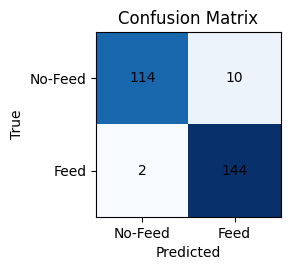

In [8]:
# Evaluation
def report(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x).argmax(1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0

    print(f'Accuracy   : {acc:.4f}')
    print(f'Precision  : {prec:.4f}')
    print(f'Recall     : {rec:.4f}')
    print(f'F1         : {f1:.4f}')
    print(f'Specificity: {spec:.4f}')
    print(f'FPR        : {fpr:.4f}')

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, cmap='Blues')
    plt.xticks([0, 1], ['No‑Feed', 'Feed'])
    plt.yticks([0, 1], ['No‑Feed', 'Feed'])
    plt.title('Confusion Matrix')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

report(val_dl)